## Setup

Before preparing the data, there are some initial steps required for setup.


This notebook requires two additional Python packages:
* **OpenCV** is required for gathering image sizes and flipping of images horizontally.
* The **MXNet** runtime is required for using the im2rec tool.

In [139]:
# These packages are needed to use OpenCV in Studio as of February 2022
import platform
if platform.linux_distribution()[0] == "debian":
    ! apt-get update
    ! apt-get install ffmpeg libsm6 libxext6  -y

In [140]:
import sys

!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install mxnet

We need to identify the S3 bucket that you want to use for providing training and validation datasets.  It will also be used to store the tranied model artifacts. In this notebook, we use a custom bucket. You could alternatively use a default bucket for the session.  We use an object prefix to help organize the bucket content.

In [3]:
import sagemaker

bucket = sagemaker.Session().default_bucket()
prefix = "DEMO-ObjectDetection-birds"

print("s3://{}/{}/".format(bucket, prefix))

s3://sagemaker-us-east-2-867949426769/DEMO-ObjectDetection-birds/


To train the Object Detection algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with, we need an AWS account role with SageMaker access. Here we will use the execution role the current notebook instance was given when it was created.  This role has necessary permissions, including access to your data in S3.

In [4]:
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::867949426769:role/service-role/AmazonSageMaker-ExecutionRole-20220320T212780


# Data Preparation

## Download and unpack the dataset

In [5]:
import os
import urllib.request
import zipfile


def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

In [13]:
%%time

dataset_key = "project_huntcontrol-simple_dataset-2022_03_24_12_18_40-coco.zip"
dataset_s3_url = "https://hunt-cvat-dataset.s3.us-east-2.amazonaws.com/" + dataset_key
dataset_folder = "huntcontrol_simple_dataset"
IMAGES_DIR = dataset_folder + "/images"
dataset_annotation_json = dataset_folder + '/annotations/instances_default.json'


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 13.6 µs


Now we unpack the dataset into its own directory structure.

In [23]:
download(dataset_s3_url)

!rm -rf $dataset_folder
with zipfile.ZipFile(dataset_key, 'r') as zip_ref:
    zip_ref.extractall(dataset_folder)
!rm $dataset_key

In [24]:
import pandas as pd
import cv2
import boto3
import json

f = open(dataset_annotation_json)
data = json.load(f)
for i in data['categories']:
    print(i)


{'id': 1, 'name': 'deer', 'supercategory': ''}
{'id': 2, 'name': 'hog', 'supercategory': ''}
{'id': 3, 'name': 'turkey', 'supercategory': ''}
{'id': 4, 'name': 'people', 'supercategory': ''}


## Prepare annotation data

484
969


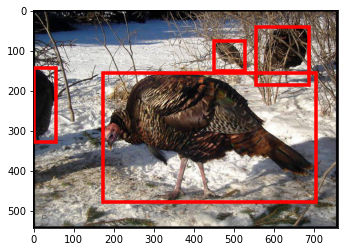

In [25]:
from imageio import imread
import scipy.io as sio
import shutil
from PIL import Image

categories = data['categories']
annotations = data['annotations']
images = data['images']

IM_COUNT = len(images)
print(len(images))
print(len(annotations))
    
    
folder_hunt_train = 'hunt-train'
folder_hunt_train_annotation = 'hunt-train_annotation'
folder_hunt_validation = 'hunt-validation'
folder_hunt_validation_annotation = 'hunt-validation_annotation'

!rm -rf $folder_hunt_train
!rm -rf $folder_hunt_train_annotation
!rm -rf $folder_hunt_validation
!rm -rf $folder_hunt_validation_annotation

os.mkdir(folder_hunt_train)
os.mkdir(folder_hunt_train_annotation)
os.mkdir(folder_hunt_validation)
os.mkdir(folder_hunt_validation_annotation)

import matplotlib.pyplot as plt
count = 0
for img_obj in images :
    img_old = img_obj['file_name']  
    image_file_old = IMAGES_DIR + '/' + img_old 
        
    img = img_old.replace("/", "_")
    img_flip = "flip_" + img
    jsonFile = img.split('.')[0]+'.json'
    jsonFile_flip = img_flip.split('.')[0]+'.json'
            
    shape = imread(image_file_old).shape
    line = {}
    line['file'] = img
    line['image_size'] = [{
        'width':int(shape[1]),
        'height':int(shape[0]),
        'depth':3
    }]
     
    line['annotations'] = []
    line['categories'] = [] 
    
    line_flip = {}
    line_flip['file'] = img_flip
    line_flip['image_size'] = [{
        'width':int(shape[1]),
        'height':int(shape[0]),
        'depth':3
    }]
     
    line_flip['annotations'] = []
    line_flip['categories'] = [] 
    #print(annotations)
    for anno in annotations:
         if(anno['image_id']==img_obj['id']):
            category_id = anno['category_id'] - 1
            annotation = {
                    'class_id':category_id,
                    'left':anno['bbox'][0],
                    'top':anno['bbox'][1],
                    'width':anno['bbox'][2],
                    'height':anno['bbox'][3],
            }
            line['annotations'].append(annotation)
            class_name = categories[category_id]['name']
            assert class_name is not ''
            line['categories'].append({
                'class_id':category_id,
                'name':class_name
            })
            
            annotation_flip = {
                    'class_id':category_id,
                    'left':int(shape[1]) - annotation['width'] - annotation['left'],
                    'top':anno['bbox'][1],
                    'width':anno['bbox'][2],
                    'height':anno['bbox'][3],
            }
            line_flip['annotations'].append(annotation_flip)
            class_name = categories[category_id]['name']
            assert class_name is not ''
            line_flip['categories'].append({
                'class_id':category_id,
                'name':class_name
            })            
            
   
    if line['annotations']:
        img_object = Image.open(image_file_old)
        img_flip_object = img_object.transpose(Image.FLIP_LEFT_RIGHT)
        img_flip_object.save('./'+folder_hunt_train+'/' + img_flip)
        with open(os.path.join(folder_hunt_train_annotation, jsonFile_flip),'w') as p:
            json.dump(line_flip,p)    
        
        count += 1
        if count % 4 == 0:
            shutil.move(image_file_old, './'+folder_hunt_validation+'/' + img)
            with open(os.path.join(folder_hunt_validation_annotation, jsonFile),'w') as p:
                json.dump(line,p)      
        else:
            shutil.move(image_file_old, './' + folder_hunt_train + '/' + img)
            with open(os.path.join(folder_hunt_train_annotation, jsonFile),'w') as p:
                json.dump(line,p)    
        
        if count == 198 :
            a = plt.imread('./'+folder_hunt_train+'/' + img_flip)
            plt.imshow(a)
            for annotation in line_flip['annotations'] :
                xmin = int(annotation['left'])
                ymin = int(annotation['top'])
                width = int(annotation['width'])
                height = int(annotation['height'])
                rect = plt.Rectangle(
                    (xmin, ymin),
                    width,
                    height,
                    fill=False,
                    edgecolor='r',
                    linewidth=3.5,
                )
                plt.gca().add_patch(rect)
            
   
# Clean up
# plt.close()      

In [27]:

train_channel = prefix + '/car-train'
validation_channel = prefix + '/car-validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

sess.upload_data(path=folder_hunt_train, bucket=bucket, key_prefix=train_channel)
sess.upload_data(path=folder_hunt_validation, bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path=folder_hunt_train_annotation, bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path=folder_hunt_validation_annotation, bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

# Train the model

Next we define an output location in S3, where the model artifacts will be placed on completion of the training. These artifacts are the output of the algorithm's traning job.  We also get the URI to the Amazon SageMaker Object Detection docker image.  This ensures the estimator uses the correct algorithm from the current region.

In [28]:
runtime = boto3.client(service_name="runtime.sagemaker")
from sagemaker import image_uris

training_image = image_uris.retrieve(
    region=sess.boto_region_name, framework="object-detection", version="latest"
)
print(training_image)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


825641698319.dkr.ecr.us-east-2.amazonaws.com/object-detection:1


In [29]:
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)

In [30]:
od_model = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    volume_size=50,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sess,
)

## Define hyperparameters

The object detection algorithm at its core is the [Single-Shot Multi-Box detection algorithm (SSD)](https://arxiv.org/abs/1512.02325). This algorithm uses a `base_network`, which is typically a [VGG](https://arxiv.org/abs/1409.1556) or a [ResNet](https://arxiv.org/abs/1512.03385). The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50. It also has a number of hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. See the SageMaker Object Detection [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html) for more details on its specific hyperparameters.

One of the hyperparameters here for example is `epochs`. This defines how many passes of the dataset we iterate over and drives the training time of the algorithm. Based on our tests, we can achieve 70% accuracy on a sample mix of 5 species with 100 epochs.  When using the full 200 species, we can achieve 52% accuracy with 1,200 epochs.

Note that Amazon SageMaker also provides [Automatic Model Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html).  Automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose.  When [tuning an Object Detection](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection-tuning.html) algorithm for example, the tuning job could find the best `validation:mAP` score by trying out various values for certain hyperparameters such as `mini_batch_size`, `weight_decay`, and `momentum`.

In [34]:
def set_hyperparameters(num_epochs, lr_steps):
    jsons = os.listdir(folder_hunt_train_annotation)
    
    num_classes = len(categories)
    num_training_samples = len(jsons)

    print("num classes: {}, num training images: {}".format(num_classes, num_training_samples))

    od_model.set_hyperparameters(
        base_network="resnet-50",
        use_pretrained_model=1,
        num_classes=num_classes,
        mini_batch_size=16,
        epochs=num_epochs,
        learning_rate=0.001,
        lr_scheduler_step=lr_steps,
        lr_scheduler_factor=0.1,
        optimizer="sgd",
        momentum=0.9,
        weight_decay=0.0005,
        overlap_threshold=0.5,
        nms_threshold=0.45,
        image_shape=512,
        label_width=350,
        num_training_samples=num_training_samples,
    )

In [35]:
set_hyperparameters(100, "33,67")

num classes: 4, num training images: 844


Now that the hyperparameters are setup, we define the data channels to be passed to the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.  Note that you could add a third channel named `model` to perform incremental training (continue training from where you had left off with a prior model).

In [36]:
train_data = sagemaker.inputs.TrainingInput(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.inputs.TrainingInput(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.inputs.TrainingInput(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}



## Submit training job

We have our `Estimator` object, we have set the hyperparameters for this object, and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm using the `fit` method. This will take more than 10 minutes in our example.

The training process involves a few steps. First, the instances that we requested while creating the `Estimator` classes are provisioned and setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the actual training begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before our training job logs show up in CloudWatch. The logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset (once per epoch). This metric is a proxy for the accuracy of the model.

Once the job has finished, a `Job complete` message will be printed. The trained model artifacts can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [37]:
%%time
od_model.fit(inputs=data_channels, logs=True)

2022-03-25 20:55:41 Starting - Starting the training job...
2022-03-25 20:56:07 Starting - Preparing the instances for trainingProfilerReport-1648241741: InProgress
.........
2022-03-25 20:57:25 Downloading - Downloading input data...
2022-03-25 20:58:06 Training - Downloading the training image......
2022-03-25 20:59:09 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[03/25/2022 20:59:14 INFO 140183031600960 integration.py:636] worker started
[03/25/2022 20:59:14 INFO 140183031600960] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'base_network': 'vgg-16', 'use_pretrained_model': '0', 'num_classes': '', 'mini_batch_size': '32', 'epochs': '30', 'learning_rate': '0.001', 'lr_scheduler_step': '', 'lr_scheduler_factor': '0.1', 'optimizer': 'sgd', 'momentum': '0.9', 'weight_decay': '0.0005', 'overlap_threshold': '0.5', 'nms_threshold': '0.45', 'num_training_sample

Now that the training job is complete, you can also see the job listed in the `Training jobs` section of your SageMaker console.  Note that the job name is uniquely identified by the name of the algorithm concatenated with the date and time stamp.  You can click on the job to see the details including the hyperparameters, the data channel definitions, and the full path to the resulting model artifacts.  You could even clone the job from the console, and tweak some of the parameters to generate a new training job.

Without having to go to the CloudWatch console, you can see how the job progressed in terms of the key object detection algorithm metric, mean average precision (mAP).  This function below prepares a simple chart of that metric against the epochs.

In [38]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

client = boto3.client("logs")
BASE_LOG_NAME = "/aws/sagemaker/TrainingJobs"


def plot_object_detection_log(model, title):
    logs = client.describe_log_streams(
        logGroupName=BASE_LOG_NAME, logStreamNamePrefix=model._current_job_name
    )
    cw_log = client.get_log_events(
        logGroupName=BASE_LOG_NAME, logStreamName=logs["logStreams"][0]["logStreamName"]
    )

    mAP_accs = []
    for e in cw_log["events"]:
        msg = e["message"]
        if "validation mAP <score>=" in msg:
            num_start = msg.find("(")
            num_end = msg.find(")")
            mAP = msg[num_start + 1 : num_end]
            mAP_accs.append(float(mAP))

    print(title)
    print("Maximum mAP: %f " % max(mAP_accs))

    fig, ax = plt.subplots()
    plt.xlabel("Epochs")
    plt.ylabel("Mean Avg Precision (mAP)")
    (val_plot,) = ax.plot(range(len(mAP_accs)), mAP_accs, label="mAP")
    plt.legend(handles=[val_plot])
    ax.yaxis.set_ticks(np.arange(0.0, 1.05, 0.1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%0.2f"))
    plt.show()

mAP tracking for job: object-detection-2022-03-25-20-55-41-670
Maximum mAP: 0.838461 


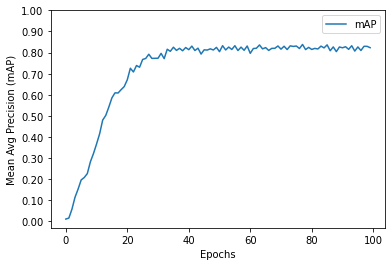

In [39]:
plot_object_detection_log(od_model, "mAP tracking for job: " + od_model._current_job_name)

# Host the model

Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This lets us make predictions (or inferences) from the model. Note that we don't have to host using the same type of instance that we used to train. Training is a prolonged and compute heavy job with different compute and memory requirements that hosting typically does not. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.m4.xlarge`. The endpoint deployment takes several minutes, and can be accomplished with a single line of code calling the `deploy` method.

Note that some use cases require large sets of inferences on a predefined body of images.  In those cases, you do not need to make the inferences in real time.  Instead, you could use SageMaker's [batch transform jobs](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html).

In [40]:
%%time
object_detector = od_model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-------!CPU times: user 124 ms, sys: 8.75 ms, total: 132 ms
Wall time: 3min 31s


# Test the model

Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference.  The results of a call to the inference endpoint are in a format that is similar to the .lst format, with the addition of a confidence score for each detected object. The format of the output can be represented as `[class_index, confidence_score, xmin, ymin, xmax, ymax]`. Typically, we don't visualize low-confidence predictions.

We have provided a script to easily visualize the detection outputs. You can visulize the high-confidence preditions with bounding box by filtering out low-confidence detections using the script below:

In [41]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
    """
    visualize detections in one image
    Parameters:
    ----------
    img : numpy.array
        image, in bgr format
    dets : numpy.array
        ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
        each row is one object
    classes : tuple or list of str
        class names
    thresh : float
        score threshold
    """
    import random
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    img = mpimg.imread(img_file)
    plt.imshow(img)
    height = img.shape[0]
    width = img.shape[1]
    colors = dict()
    num_detections = 0
    for det in dets:
        (klass, score, x0, y0, x1, y1) = det
        if score < thresh:
            continue
        num_detections += 1
        cls_id = int(klass)
        if cls_id not in colors:
            colors[cls_id] = (random.random(), random.random(), random.random())
        xmin = int(x0 * width)
        ymin = int(y0 * height)
        xmax = int(x1 * width)
        ymax = int(y1 * height)
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor=colors[cls_id],
            linewidth=3.5,
        )
        plt.gca().add_patch(rect)
        class_name = str(cls_id)
        if categories and len(categories) > cls_id:
            class_name = categories[cls_id]['name']
        print("{},{}".format(class_name, score))
        plt.gca().text(
            xmin,
            ymin - 2,
            "{:s} {:.3f}".format(class_name, score),
            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
            fontsize=12,
            color="white",
        )

    print("Number of detections: " + str(num_detections))
    plt.show()

Now we use our endpoint to try to detect objects within an image. Since the image is a jpeg, we use the appropriate content_type to run the prediction. The endpoint returns a JSON object that we can simply load and peek into. We have packaged the prediction code into a function to make it easier to test other images.  Note that we are defaulting the confidence threshold to 30% in our example, as a couple of the birds in our sample images were not being detected as clearly.  Defining an appropriate threshold is entirely dependent on your use case.

In [42]:
def show_bird_prediction(filename, ep, thresh=0.40):
    b = ""
    with open(filename, "rb") as image:
        f = image.read()
        b = bytearray(f)
    endpoint_response = runtime.invoke_endpoint(EndpointName=ep, ContentType="image/jpeg", Body=b)
    results = endpoint_response["Body"].read()
    detections = json.loads(results)
    visualize_detection(filename, detections["prediction"], [], thresh)

Here we download images that the algorithm has not yet seen.

object-detection-2022-03-25-21-47-29-969
turkey,0.9292310476303101
Number of detections: 1


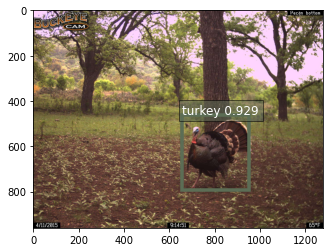

deer,0.8428758978843689
Number of detections: 1


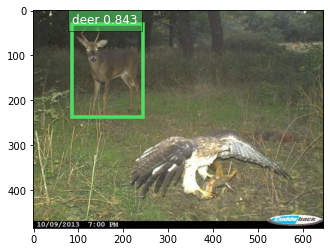

people,0.5920338034629822
Number of detections: 1


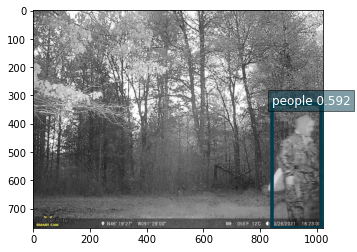

hog,0.8054905533790588
Number of detections: 1


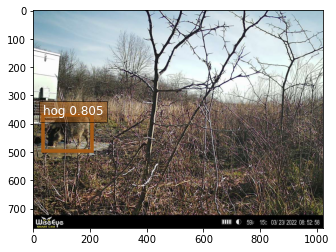

In [43]:
print(object_detector.endpoint_name)
def test_model():
    show_bird_prediction("hunt-validation/turkey0006.jpg", object_detector.endpoint_name)
    show_bird_prediction("hunt-validation/deer10003.jpg", object_detector.endpoint_name)
    show_bird_prediction("hunt-validation/People_861641041470484-file20211026182406KX0CL.JPG", object_detector.endpoint_name)
    show_bird_prediction("hunt-validation/Hog_865814043034162-file202203230921484FVOY.JPG", object_detector.endpoint_name)

test_model()

# Clean up
Here we delete the SageMaker endpoint, as we will no longer be performing any inferences.  This is an important step, as your account is billed for the amount of time an endpoint is running, even when it is idle.

In [32]:
sagemaker.Session().delete_endpoint(object_detector.endpoint_name)

# Improve the model

## Define Function to Flip the Images Horizontally (on the X Axis)

## Re-train the model with the expanded dataset

Flipping images...
Done looping through original images
Done saving metadata in text files
Species 017.Cardinal has 114 images.


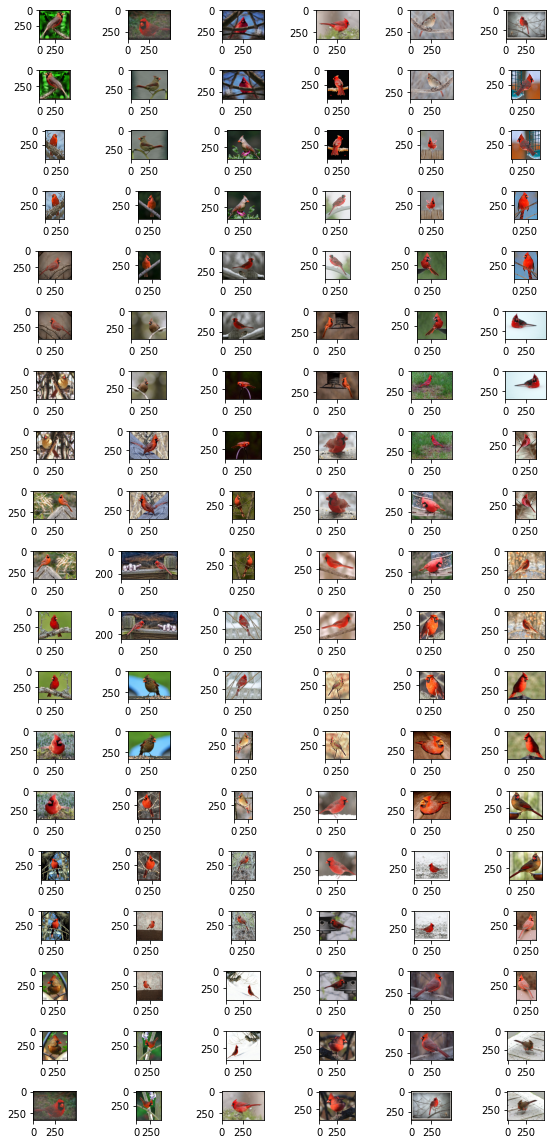

Generating a file containing image sizes...
Image sizes:
   idx  width  height
0    1    500     335
1    2    500     336
2    3    500     347
3    4    415     500
4    5    331     380
CUB_200_2011/images_with_flip.txt
num images total: 12085
num train: 300
num val: 294
Creating .rec file from /home/ec2-user/SageMaker/hunt-sage-notebook/birds_ssd_sample_val.lst in /home/ec2-user/SageMaker/hunt-sage-notebook
multiprocessing not available, fall back to single threaded encoding
time: 0.007176399230957031  count: 0
Creating .rec file from /home/ec2-user/SageMaker/hunt-sage-notebook/birds_ssd_sample_train.lst in /home/ec2-user/SageMaker/hunt-sage-notebook
multiprocessing not available, fall back to single threaded encoding
time: 0.006376028060913086  count: 0
num classes: 5, num training images: 300
2022-03-24 16:15:29 Starting - Starting the training job...
2022-03-24 16:15:54 Starting - Preparing the instances for trainingProfilerReport-1648138529: InProgress
.........
2022-03-24 16:1

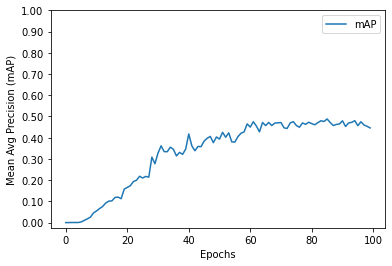

CPU times: user 1min 4s, sys: 1.37 s, total: 1min 5s
Wall time: 22min 10s


In [34]:
%%time

BBOX_FILE = BASE_DIR + "bounding_boxes_with_flip.txt"
IMAGE_FILE = BASE_DIR + "images_with_flip.txt"
LABEL_FILE = BASE_DIR + "image_class_labels_with_flip.txt"
SIZE_FILE = BASE_DIR + "sizes_with_flip.txt"
SPLIT_FILE = BASE_DIR + "train_test_split_with_flip.txt"

# add a set of flipped images
flip_images()

# show the new full set of images for a species
show_species("017.Cardinal")

# create new sizes file
gen_image_size_file()

# re-create and re-deploy the RecordIO files with the updated set of images
train_df, val_df = gen_list_files()
!python tools/im2rec.py --resize $RESIZE_SIZE --pack-label birds_ssd_sample $BASE_DIR/images/
sess.upload_data(path="birds_ssd_sample_train.rec", bucket=bucket, key_prefix=train_channel)
sess.upload_data(path="birds_ssd_sample_val.rec", bucket=bucket, key_prefix=validation_channel)

# account for the new number of training images
set_hyperparameters(100, "33,67")

# re-train
od_model.fit(inputs=data_channels, logs=True)

# check out the new accuracy
plot_object_detection_log(od_model, "mAP tracking for job: " + od_model._current_job_name)

## Re-deploy and test

-------!Number of detections: 0


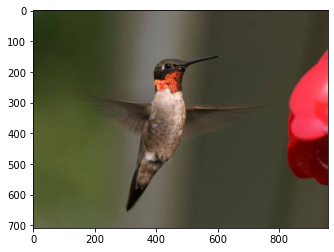

Number of detections: 0


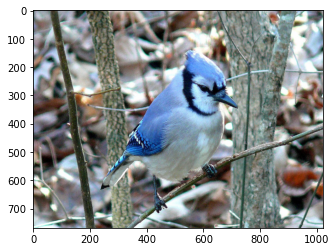

047.American_Goldfinch,0.7068172693252563
047.American_Goldfinch,0.49259746074676514
Number of detections: 2


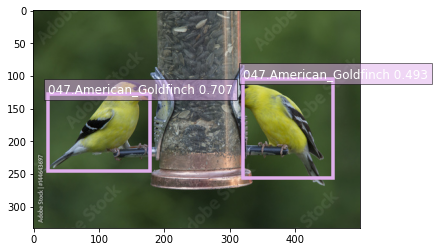

036.Northern_Flicker,0.5421158075332642
Number of detections: 1


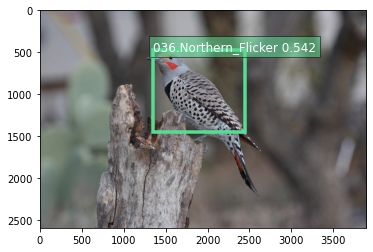

Number of detections: 0


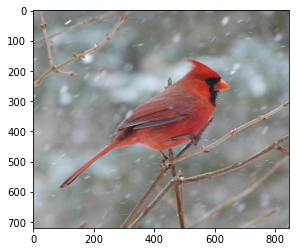

In [35]:
# host the updated model
object_detector = od_model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

# test the new model
test_model()

## Final cleanup
Here we delete the SageMaker endpoint, as we will no longer be performing any inferences.  This is an important step, as your account is billed for the amount of time an endpoint is running, even when it is idle.

In [36]:
# delete the new endpoint
sagemaker.Session().delete_endpoint(object_detector.endpoint_name)